In [1]:
import os
import re
import shutil
import random
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, copy, argparse
import multiprocessing
from torchinfo import summary
from matplotlib import pyplot as plt
import timm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, classification_report, accuracy_score, precision_score, recall_score, f1_score
import cv2
from sklearn.manifold import TSNE
from collections import defaultdict, Counter
import pandas as pd
import openpyxl

In [2]:
destination_directory = "/data/home/bt18037/UltraBC"

In [3]:
# Set the train and validation directory paths

train_directory = os.path.join(destination_directory, 'Full Dataset', 'train')
valid_directory = os.path.join(destination_directory, 'Full Dataset', 'val')

# Set the checkpoint directory path
checkpoint_directory = os.path.join(destination_directory, 'checkpoint_ViT_B_16')

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_directory, exist_ok=True)

# Now you can set your model save path
model_save_path = os.path.join(checkpoint_directory, 'ViT_B_16.pth')

print(f"Checkpoint directory created at: {checkpoint_directory}")
print(f"Model will be saved at: {model_save_path}")

Checkpoint directory created at: /data/home/bt18037/UltraBC/checkpoint_ViT_B_16
Model will be saved at: /data/home/bt18037/UltraBC/checkpoint_ViT_B_16/ViT_B_16.pth


In [4]:
# Batch size
bs = 32 
# Number of epochs
num_epochs = 50
# Number of classes
num_classes = 2

In [5]:
# Applying transforms to the data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomVerticalFlip(0.3),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.RandomErasing(0.4, scale=(0.02, 0.10)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [6]:
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

In [7]:
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

# Create iterators for data loading
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=0, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                            num_workers=0, pin_memory=True, drop_last=True)
}

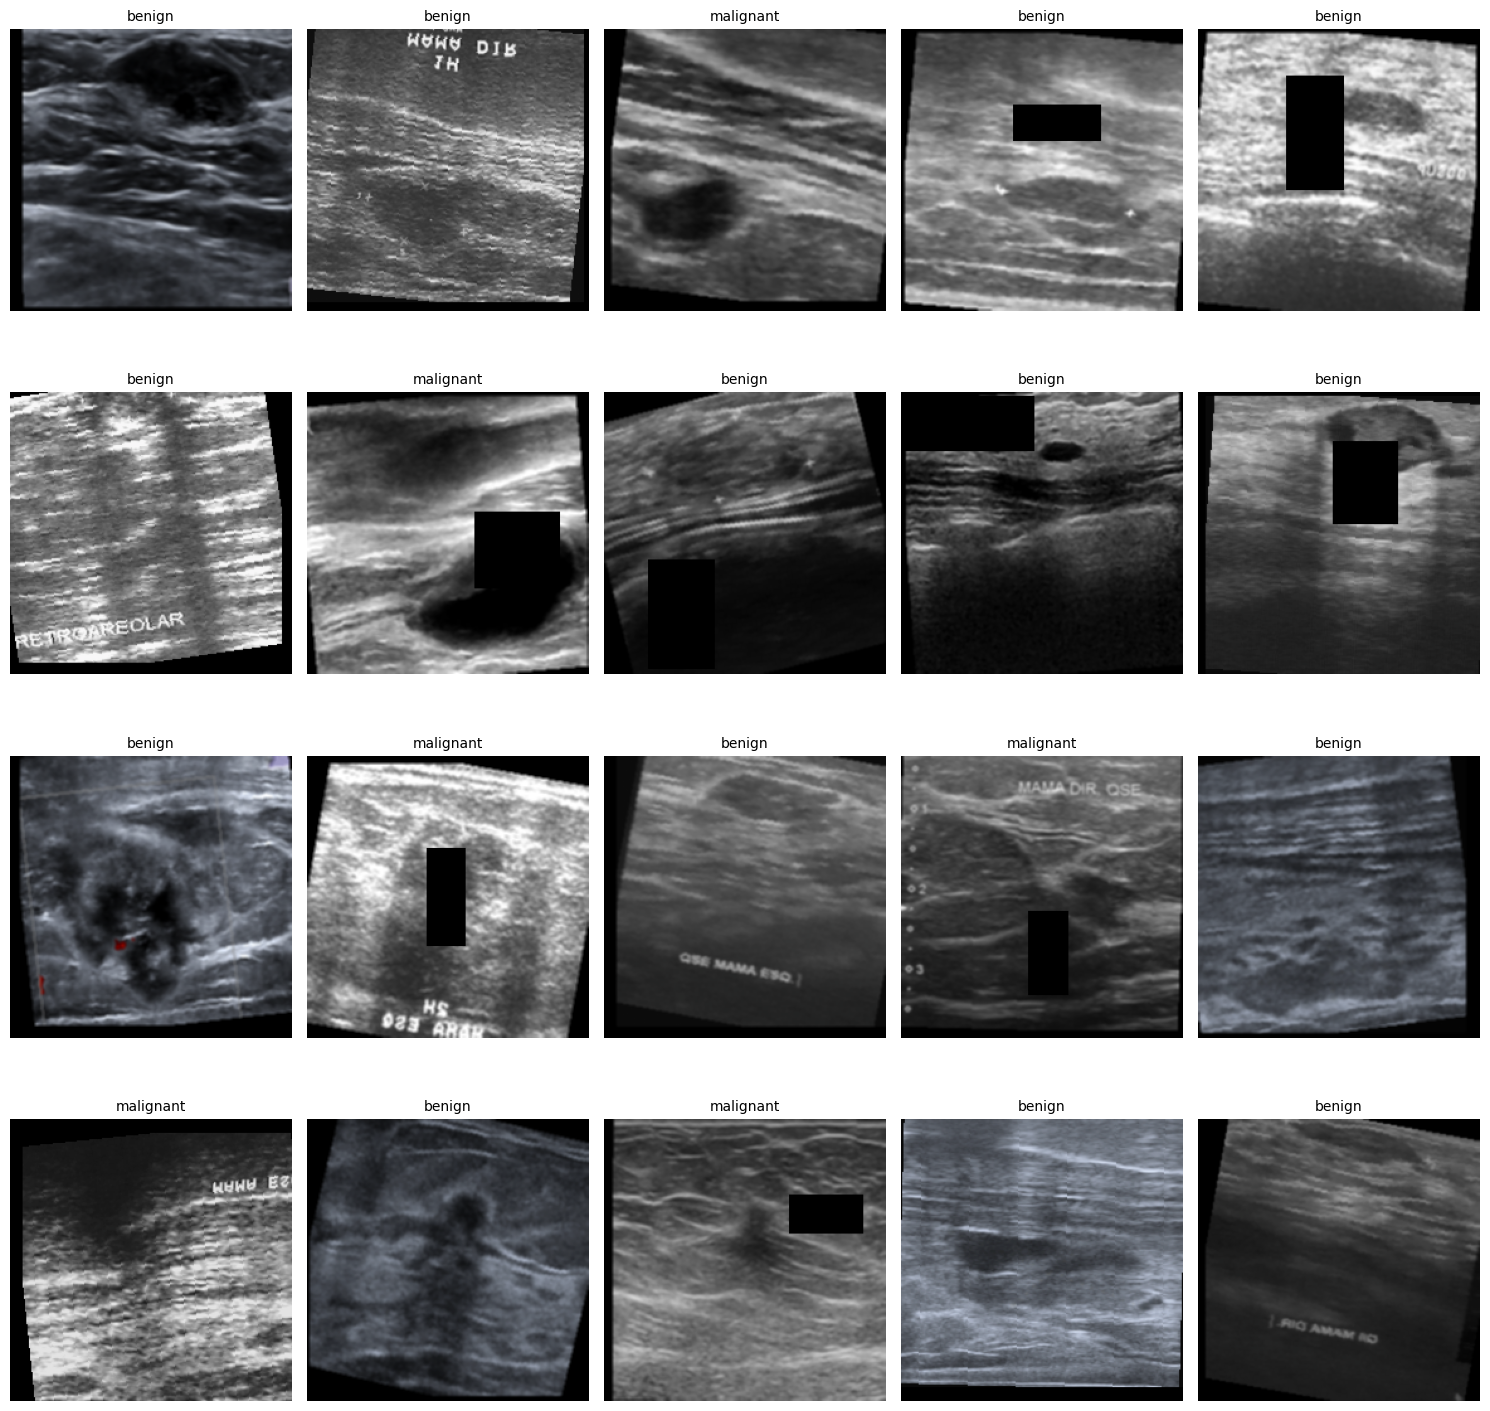

In [8]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

class_names = dataset['train'].classes

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Plot 16 images from a batch 
batch_size = min(20, len(inputs))
fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.ravel()

for i in range(batch_size):
    img = denormalize(inputs[i].unsqueeze(0)).squeeze(0).permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].set_title(f'{class_names[labels[i].item()]}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(checkpoint_directory, "Sample Images from Training Dataset with Augmentation__1.png"), dpi=300, bbox_inches='tight')

plt.show()


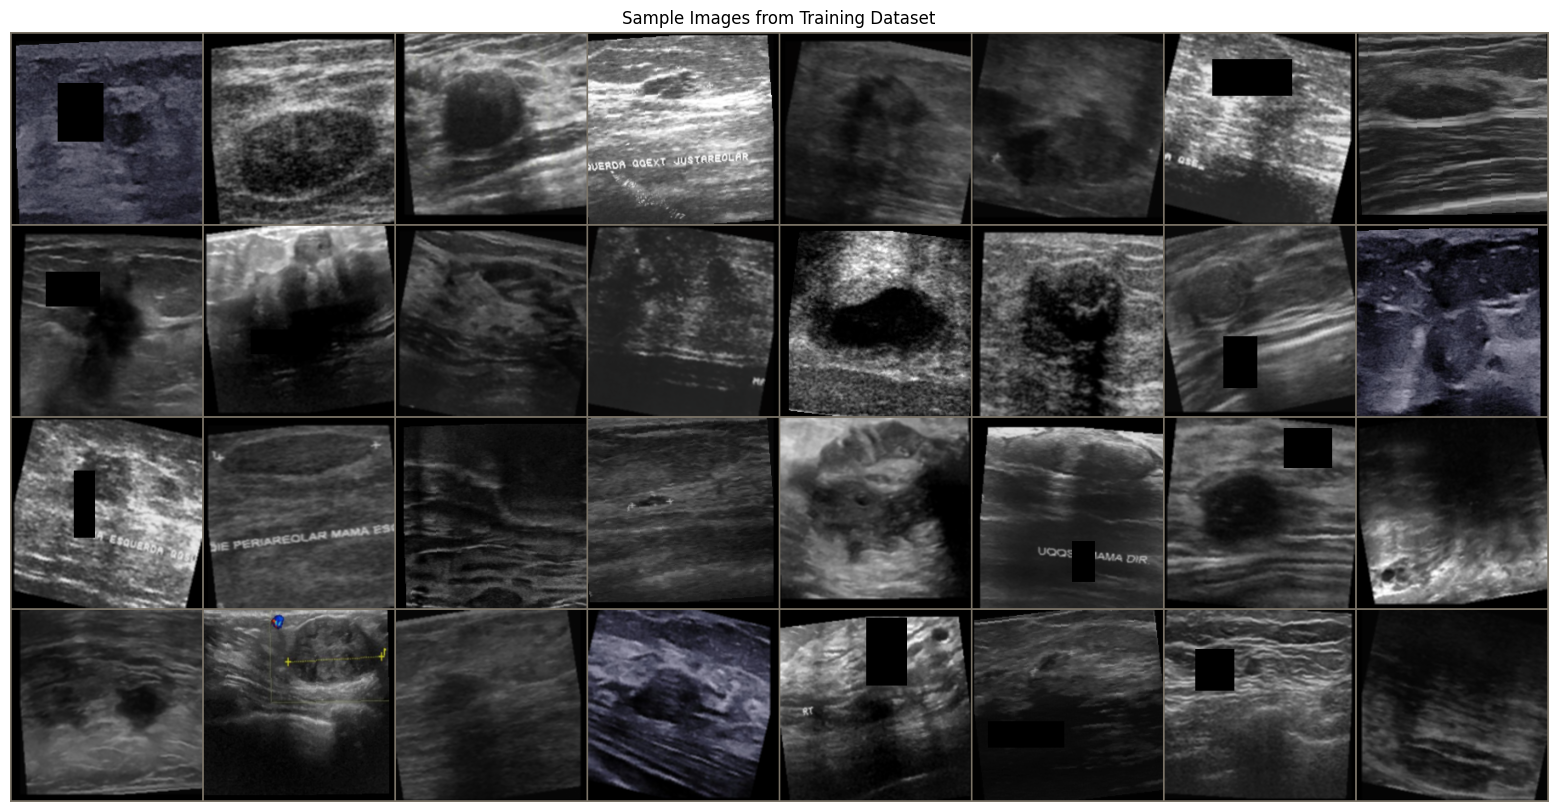

Labels: tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0])


In [9]:
# Function to denormalize images
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot images
plt.figure(figsize=(20, 10))
plt.imshow(denormalize(out).squeeze(0).permute(1, 2, 0))  # Add squeeze(0) before permute
plt.axis('off')
plt.title('Sample Images from Training Dataset')
plt.savefig(os.path.join(checkpoint_directory, "Sample Images from Training Dataset with Augmentation.png"), dpi=300, bbox_inches='tight')

plt.show()

# Print labels
print('Labels:', labels)

In [10]:
# Class names or target labels

class_names = dataset['train'].classes
print("Classes:", class_names)

train_labels = dataset['train'].targets
valid_labels = dataset['valid'].targets

train_counts = Counter(train_labels)
valid_counts = Counter(valid_labels)

print("\nTrain set:")
for idx, class_name in enumerate(class_names):
    print(f"   {class_name}: {train_counts.get(idx, 0)}")

print("\nValid set:")
for idx, class_name in enumerate(class_names):
    print(f"   {class_name}: {valid_counts.get(idx, 0)}")

print("\nTraining set size:", len(dataset['train']),
      "\nValidation set size:", len(dataset['valid']))


Classes: ['benign', 'malignant']

Train set:
   benign: 1822
   malignant: 1124

Valid set:
   benign: 366
   malignant: 268

Training set size: 2946 
Validation set size: 634


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device: cuda:0 (NVIDIA A100-PCIE-40GB)


In [12]:
print("\nLoading ViT_B_16 for finetuning ...\n")

model = torchvision.models.vit_b_16(weights='DEFAULT')

fc_in_features = model.heads[0].in_features
print(f"Input features to the classifier head: {fc_in_features}")


'''
model.heads = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(fc_in_features, 384),
    torch.nn.BatchNorm1d(384),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(384, 192),
    torch.nn.BatchNorm1d(192),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(192, num_classes)
)
'''

model.heads = torch.nn.Linear(model.heads[0].in_features, num_classes)

model_ft = model.cuda()

model_ft = model_ft.to(device)

print(model.heads)


Loading ViT_B_16 for finetuning ...

Input features to the classifier head: 768
Linear(in_features=768, out_features=2, bias=True)


In [13]:
# Print model summary
'''print('Model Summary:-\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(3, 224, 224))
'''
print(model_ft)

print("\nModel Summary using torchinfo:")
print("-" * 50)
summary(model_ft, input_size=(1, 3, 224, 224), verbose=1)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 2]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [14]:
from sklearn.utils.class_weight import compute_class_weight

# Extract training labels
train_labels = dataset['train'].targets

# Get the class indices
class_names = dataset['train'].classes
class_indices = np.arange(len(class_names))

# Compute balanced class weights
class_weights = compute_class_weight(class_weight='balanced', classes=class_indices, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

for cls, weight in zip(class_names, class_weights.cpu().numpy()):
    print(f"Class '{cls}' weight: {weight:.4f}")

Class 'benign' weight: 0.8085
Class 'malignant' weight: 1.3105


In [15]:
# Create the weighted loss function
criterion = nn.CrossEntropyLoss()

In [16]:
## optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

optimizer_ft = optim.AdamW(model_ft.parameters(), lr=1e-4, weight_decay=1e-3)

In [17]:
# exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=40)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [18]:
import time
import copy
import os
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

'''
# Progressive unfreezing function
def unfreeze_last_encoder_blocks(model, num_blocks_to_unfreeze):
    total_blocks = len(model.encoder.layers)
    for i in range(total_blocks - num_blocks_to_unfreeze, total_blocks):
        for param in model.encoder.layers[i].parameters():
            param.requires_grad = True


# Initial freezing setup
def freeze_all_except_classifier(model):
    for param in model.parameters():
        param.requires_grad = False
    for param in model.heads.parameters():
        param.requires_grad = True
'''

# Model training routine
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy values
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Tensorboard summary
    writer = SummaryWriter()

    # Freeze all except classifier initially
    # freeze_all_except_classifier(model)

    # Tracking how many blocks are unfrozen
    # progressively_unfrozen_blocks = 0

    # total_blocks = len(model.encoder.layers)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Unfreeze 2 more blocks every 5 epochs (starting after epoch 0)
        '''if epoch % 10 == 0 and epoch != 0:
            progressively_unfrozen_blocks = min(progressively_unfrozen_blocks + 2, total_blocks)
            print(f"Unfreezing last {progressively_unfrozen_blocks} transformer blocks.")
            unfreeze_last_encoder_blocks(model, progressively_unfrozen_blocks)'''
        
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
            else:
                valid_losses.append(epoch_loss)
                valid_accs.append(epoch_acc.item())
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plotting the training and validation loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), valid_losses, label='Valid Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label='Train Accuracy')
    plt.plot(range(num_epochs), valid_accs, label='Valid Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(checkpoint_directory, "Training Loss & Accuracy Curves.png"), dpi=300, bbox_inches='tight')

    plt.show()
    
    return model

Epoch 0/49
----------
train Loss: 0.6806 Acc: 0.6093
valid Loss: 0.6337 Acc: 0.5489

Epoch 1/49
----------
train Loss: 0.5974 Acc: 0.6850
valid Loss: 0.5251 Acc: 0.7114

Epoch 2/49
----------
train Loss: 0.5320 Acc: 0.7363
valid Loss: 0.5274 Acc: 0.7050

Epoch 3/49
----------
train Loss: 0.5025 Acc: 0.7566
valid Loss: 0.5055 Acc: 0.7082

Epoch 4/49
----------
train Loss: 0.4699 Acc: 0.7777
valid Loss: 0.4929 Acc: 0.7287

Epoch 5/49
----------
train Loss: 0.4545 Acc: 0.7916
valid Loss: 0.5236 Acc: 0.6956

Epoch 6/49
----------
train Loss: 0.4244 Acc: 0.7987
valid Loss: 0.6251 Acc: 0.6798

Epoch 7/49
----------
train Loss: 0.4261 Acc: 0.8004
valid Loss: 0.5464 Acc: 0.7129

Epoch 8/49
----------
train Loss: 0.4011 Acc: 0.8211
valid Loss: 0.4492 Acc: 0.7650

Epoch 9/49
----------
train Loss: 0.3741 Acc: 0.8374
valid Loss: 0.5981 Acc: 0.7256

Epoch 10/49
----------
train Loss: 0.3724 Acc: 0.8377
valid Loss: 0.5169 Acc: 0.7256

Epoch 11/49
----------
train Loss: 0.3730 Acc: 0.8289
valid Loss

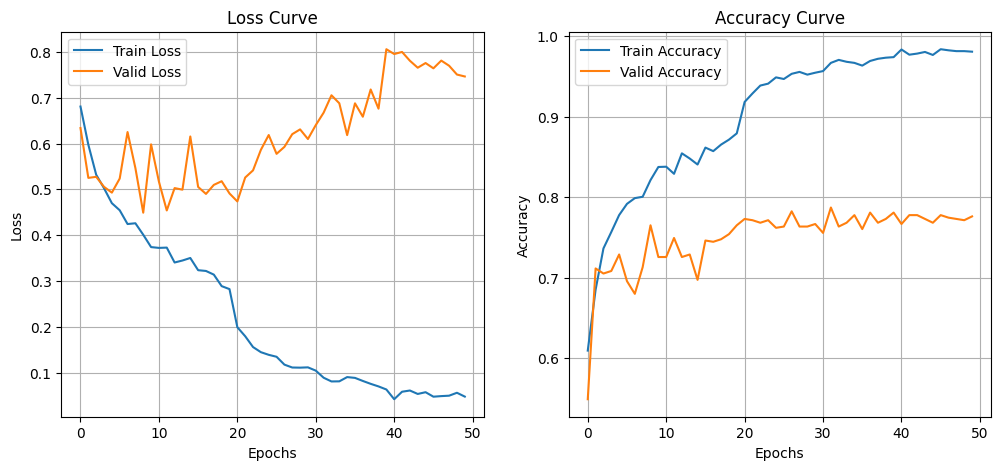


Saving the model...


In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
# Save the entire model§
print("\nSaving the model...")
torch.save(model_ft, model_save_path)

### Evaluating the model

In [14]:
EVAL_DIR = os.path.join(destination_directory, 'Full Dataset', 'test')
EVAL_MODEL= model_save_path 
print(EVAL_DIR)

/data/home/bt18037/UltraBC/Full Dataset/test


In [15]:
model = torch.load(EVAL_MODEL, weights_only = False)
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [22]:
eval_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

eval_dataset = datasets.ImageFolder(root=EVAL_DIR, transform=eval_transform)
eval_loader = data.DataLoader(eval_dataset, batch_size=bs, shuffle=True,
                              num_workers=0, pin_memory=True)

In [23]:
num_classes = len(eval_dataset.classes)
dsize = len(eval_dataset)

In [24]:
class_names = ['Benign', 'Malignant']

In [25]:
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

In [26]:
correct = 0
total = 0
predlist = torch.tensor([])  # to store the predicted labels
lbllist = torch.tensor([])   # to store the true labels
all_probs = torch.tensor([])  # to store probabilities for ROC curve

In [27]:
model.eval()  # Ensure the model is in evaluation mode

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [28]:
with torch.no_grad():
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Get probabilities using softmax
        probs = torch.softmax(outputs, dim=1)
        all_probs = torch.cat([all_probs, probs.cpu()])
        
        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predlist = torch.cat([predlist, predicted.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

# Convert lbllist and predlist to integers for bincount
lbllist = lbllist.to(torch.int64)
predlist = predlist.to(torch.int64)

# Convert to numpy arrays
y_true = lbllist.numpy()
y_pred = predlist.numpy()

# Get the classification report
report = classification_report(y_true, y_pred, target_names = class_names, digits = 4, output_dict = True)

# Put the classification report in a Pandas Dataframe
report_df = pd.DataFrame(report).transpose().round(4)

# Print classification report
print(report_df)

# Get accuracy, precision, recall, f1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average = 'weighted')
recall = recall_score(y_true, y_pred, average = 'weighted')
f1 = f1_score(y_true, y_pred, average = 'weighted')

# Store metric data in a dataframe
metrics_df = (pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})).round(4)

print(metrics_df)

# Save to an Excel file
metrics_file = os.path.join(checkpoint_directory, "ViT_B_16_Evaluation_Metrics.xlsx")
metrics_df.to_excel(metrics_file, index=False, engine='openpyxl')

              precision  recall  f1-score  support
Benign           0.8315  0.8768    0.8535  422.000
Malignant        0.7636  0.6914    0.7257  243.000
accuracy         0.8090  0.8090    0.8090    0.809
macro avg        0.7975  0.7841    0.7896  665.000
weighted avg     0.8067  0.8090    0.8068  665.000
      Metric   Value
0   Accuracy  0.8090
1  Precision  0.8067
2     Recall  0.8090
3   F1 Score  0.8068


Confusion Matrix
----------------
[[370  52]
 [ 75 168]] 



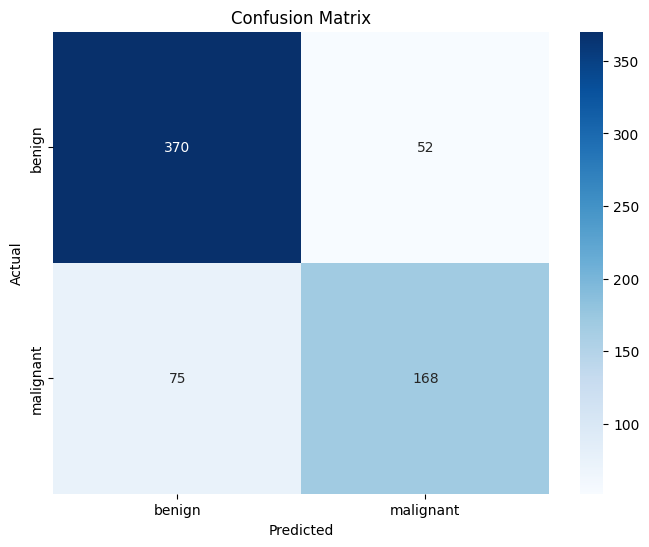

Shape of lbllist_one_hot: (665, 2)
Shape of all_probs: torch.Size([665, 2])
Class benign: AUC = 0.87
Class malignant: AUC = 0.87


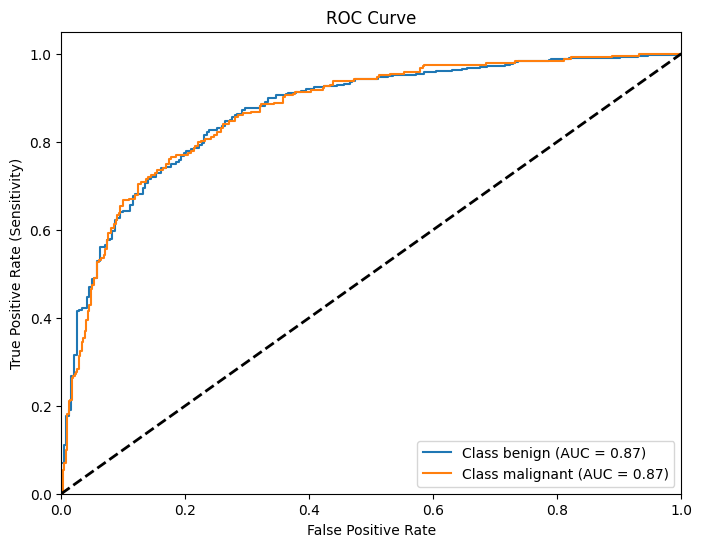

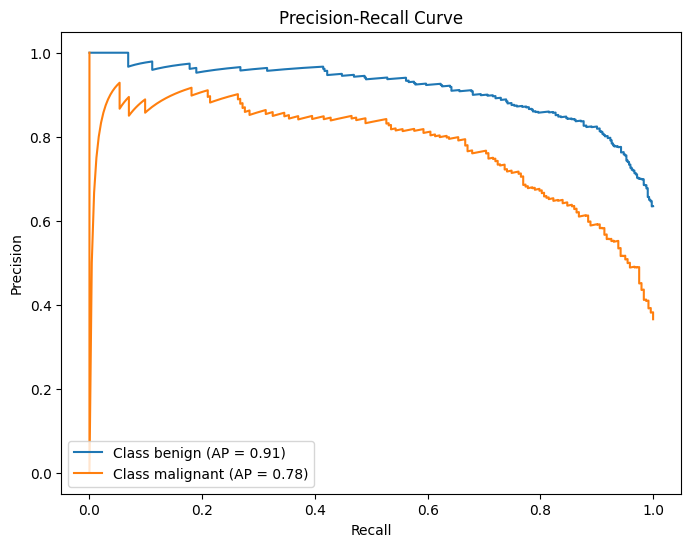

In [29]:
# Confusion Matrix
n_classes = len(eval_dataset.classes)
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy(), labels=np.arange(n_classes))  # Ensure all classes are included
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", 
            xticklabels=eval_dataset.classes, 
            yticklabels=eval_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(checkpoint_directory, "Confusion Matrix.png"), dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve and AUC
lbllist_one_hot = np.eye(n_classes)[lbllist.numpy()]  # One-hot encode the labels
fpr = {}
tpr = {}
roc_auc = {}

# Check the shapes of lbllist_one_hot and all_probs
print("Shape of lbllist_one_hot:", lbllist_one_hot.shape)
print("Shape of all_probs:", all_probs.shape)

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lbllist_one_hot[:, i], all_probs[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Class {eval_dataset.classes[i]}: AUC = {roc_auc[i]:.2f}")

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {eval_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig(os.path.join(checkpoint_directory, "ROC curve.png"), dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve and Average Precision
precision = {}
recall = {}
avg_precision = {}

# Compute Precision-Recall curve and Average Precision for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(lbllist_one_hot[:, i], all_probs[:, i].numpy())
    avg_precision[i] = average_precision_score(lbllist_one_hot[:, i], all_probs[:, i].numpy())

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {eval_dataset.classes[i]} (AP = {avg_precision[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.savefig(os.path.join(checkpoint_directory, "Precision Recall Curve.png"), dpi=300, bbox_inches='tight')
plt.show()


In [30]:
def extract_features(model, data_loader, target_layer):
    model.eval()  # Set the model to evaluation mode
    
    all_features = []
    all_labels = []

    # Hook to get the feature maps from the specified layer
    class SaveFeatures:
        def __init__(self, module):
            self.hook = module.register_forward_hook(self.hook_fn)
            self.features = None

        def hook_fn(self, module, input, output):
            self.features = output

        def close(self):
            self.hook.remove()

    # Attach hook to the target layer
    conv_output = SaveFeatures(target_layer)
    
    # Loop through the dataset
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            output = model(images)
            features = conv_output.features.cpu().detach().numpy()
            all_features.append(features)
            all_labels.append(labels.cpu().numpy())

    conv_output.close()
    
    # Stack all features and labels together
    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)
    
    return all_features, all_labels

# Function to generate t-SNE plot
def generate_tsne_plot(features, labels):
    # Flatten the feature maps if needed (depending on the layer you extract from)
    features = features.reshape(features.shape[0], -1)
    
    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    
    # Define colors and labels
    colors = ['blue', 'red']
    class_labels = ['Benign', 'Malignant']
    
    # Plot each class separately for visualization
    for class_idx in range(2):
        indices = np.where(labels == class_idx)
        plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], 
                    c=colors[class_idx], label=class_labels[class_idx])
    
    plt.title('t-SNE plot of Feature Maps')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_directory, "t-SNE Plot of Classifier Layer.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Plot t-SNE for the model classifier layer
target_layer = model.encoder.layers[11]
all_features, all_labels = extract_features(model, eval_loader, target_layer)

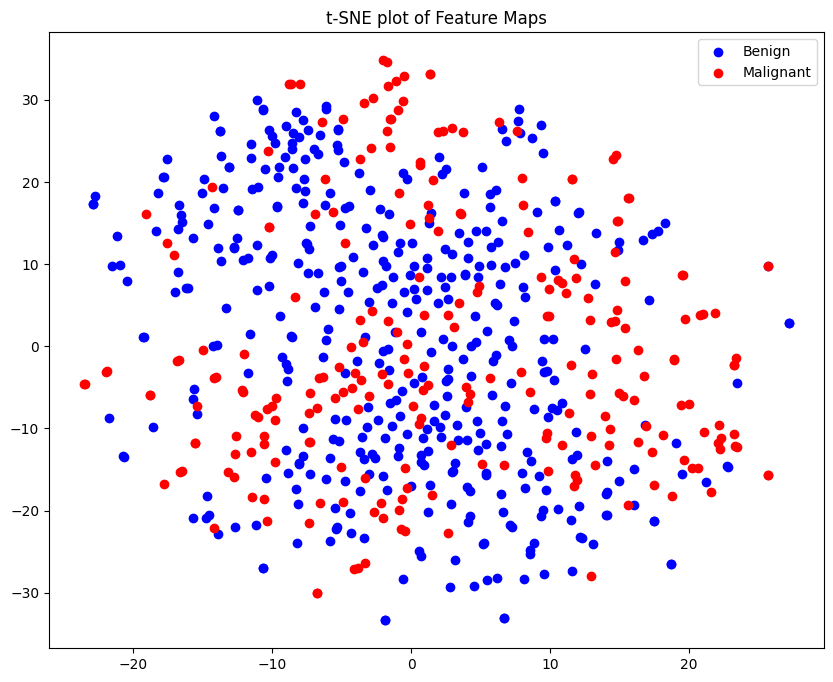

In [31]:
generate_tsne_plot(all_features, all_labels)

In [32]:
class SaveFeatures:
    def __init__(self, module):
        self.module = module
        self.features = None
        self.gradients = None
        self.hook = module.register_forward_hook(self.hook_fn)
        self.hook_grad = module.register_backward_hook(self.hook_grad_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def hook_grad_fn(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Gradient with respect to the output

    def close(self):
        self.hook.remove()
        self.hook_grad.remove()

class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()

    def __call__(self, x, class_idx=None):
        conv_output = SaveFeatures(self.target_layer)  # Hook to get feature maps and gradients
        model_output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(model_output)  # Default to the class with the highest score

        one_hot = torch.zeros((1, model_output.size()[-1]), dtype=torch.float32).to(x.device)
        one_hot[0][class_idx] = 1

        self.model.zero_grad()
        model_output.backward(gradient=one_hot, retain_graph=True)  # Backpropagate for the target class

        # Get the gradients and feature maps from the hook
        gradients = conv_output.gradients
        feature_maps = conv_output.features[0]

        # Perform global average pooling to get the weights
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Multiply feature maps by the pooled gradients
        for i in range(len(pooled_gradients)):
            feature_maps[i, :, :] *= pooled_gradients[i]

        # Average along the channel dimension to get the Grad-CAM heatmap
        heatmap = torch.mean(feature_maps, dim=0).cpu().detach().numpy()

        # Apply ReLU
        heatmap = np.maximum(heatmap, 0)

        # Normalize the heatmap
        heatmap /= np.max(heatmap)
        return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_heatmap(heatmap, img):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to uint8 format
    heatmap = np.uint8(255 * heatmap)
    
    # Apply color map (e.g., JET) to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert the original image to uint8 (if it's float32)
    if img.dtype != np.uint8:
        img = np.uint8(255 * img)
    
    # Ensure the original image has 3 channels (if it's grayscale, convert to RGB)
    if len(img.shape) == 2 or img.shape[2] == 1:  # If grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Overlay the heatmap onto the original image
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return overlayed_img

# Load your test image and preprocess
def preprocess_image(image_path, transform):
    image = cv2.imread(image_path, 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return img_tensor, image

# Function to process all images in a folder
def process_images_in_folder(folder_path, transform, model, target_layer):
    grad_cam = GradCam(model, target_layer)
    
    # Create a results folder if it doesn't exist
    results_folder = os.path.join(checkpoint_directory, 'gradcam_results')
    os.makedirs(results_folder, exist_ok=True)

    # Iterate through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):  # Add other formats if necessary
            image_path = os.path.join(folder_path, filename)
            image_tensor, original_img = preprocess_image(image_path, transform)
            
            # Run Grad-CAM
            heatmap = grad_cam(image_tensor.to(device))
            overlayed_image = overlay_heatmap(heatmap, original_img)
            
            # Save the overlayed image
            result_path = os.path.join(results_folder, f'gradcam_{filename}')
            cv2.imwrite(result_path, overlayed_image)

            # Optional: Display the result
            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(overlayed_image)
            plt.title('Grad-CAM Heatmap')
            plt.show()


def process_random_images_in_folder(folder_path, transform, model, target_layer):
    grad_cam = GradCam(model, target_layer)

    # Create a results folder if it doesn't exist
    results_folder = os.path.join(checkpoint_directory, 'gradcam_results')
    os.makedirs(results_folder, exist_ok=True)

    # Get list of all image files
    all_images = []
    for f in os.listdir(folder_path):
        if f.endswith(('.png', '.jpg')):
            all_images.append(f)

    # Randomly select 10 images
    selected_images = random.sample(all_images, min(10, len(all_images)))

    for filename in selected_images:
        image_path = os.path.join(folder_path, filename)
        image_tensor, original_img = preprocess_image(image_path, transform)

        # Run Grad-CAM
        heatmap = grad_cam(image_tensor.to(device))
        overlayed_image = overlay_heatmap(heatmap, original_img)

        # Save the overlayed image
        result_path = os.path.join(results_folder, f'gradcam_{filename}')
        cv2.imwrite(result_path, overlayed_image)

        # Optional: Display the result
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_image)
        plt.title('Grad-CAM Heatmap')
        plt.show()

In [33]:
# Example usage of Grad-CAM on 10 random in a folder
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# Final Conv2d layer in EfficientNet
target_layer = model.encoder.layers[11]

# Specify the folder containing the test images
folder_path = EVAL_DIR + '/benign' # Adjust as necessary
print(folder_path)

# Process all images in the specified folder
process_random_images_in_folder(folder_path, transform, model, target_layer)

/data/home/bt18037/UltraBC/Full Dataset/test/benign


/data/home/bt18037/.conda/envs/myenv/lib/python3.13/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)